In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_msssim
from tqdm import tqdm
from PIL import Image
import random
from collections import Counter

sys.path.append("../")
import utils.data as data
import utils.graphics as graphics
import utils.loss as loss
from models import vqvae

In [2]:
seed = 42
np.random.seed(seed)
_ = torch.manual_seed(seed)

In [3]:
batch_size = 64
num_dataloader_workers = 0

experiment_name = f"sprites_vq_vae_v3"

num_layers = 0
num_embeddings = 256
embedding_dim = 32
commitment_cost = 0.25
use_max_filters = True
max_filters = 512
image_size = 64
use_noise_images = True
small_conv = True  # To use the 1x1 convolution layer
encoding_dim = image_size // (2 ** num_layers)

data_folder = "..\\data\\Sprites\\processed"

output_dir = f"..\\outputs\\{experiment_name}"
model_path = os.path.join(output_dir, "model.pt")

In [4]:
# Setup Device
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
print(gpu, device)

False cpu


# Load Model

In [5]:
model = vqvae.VQVAE(
    num_layers=num_layers,
    input_image_dimensions=image_size,
    small_conv=small_conv,
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost,
    use_max_filters=use_max_filters,
    max_filters=max_filters,
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(256, 32)
  )
  (decoder): Sequential(
    (0): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvTranspose2d(512, 3, kernel_size=(1, 1), stride=(1, 1))
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Sigmoid()
  )
)

# Load Data

In [6]:
def load_data(data_folder, transform, num_unique_files=100):
    sprites = {}
    for file in os.listdir(data_folder):
        id_ = file.split('.')[0].split('_')[0].split('-')[0]
        form = '_'.join(file.split('.')[0].split('_')[1:])
        image = Image.open(os.path.join(data_folder, file)).convert("RGB")
        if id_ not in sprites:
            if len(sprites) == num_unique_files:
                continue
            sprites[id_] = {}
        sprites[id_][form] = transform(image)
    return sprites

In [7]:
def image_from_array(image, model_output=False):
    if model_output:
        image = image.detach().squeeze(0)
    plt.axis('off')
    plt.imshow(image.permute(1, 2, 0).numpy())

In [8]:
transform = data.image2tensor_resize(image_size)
dataset = load_data(data_folder, transform)

# Color Rotation

In [9]:
def modify_encodings(encodings, background, maximum, offset):
    encodings[encodings != background] = encodings[encodings != background] + offset
    encodings[encodings >= maximum] = encodings[encodings >= maximum] - maximum
    return encodings

In [10]:
print(random.choices(list(dataset.keys()), k=10))

['0115', '0241', '0113', '0215', '0121', '0034', '0054', '0143', '0243', '0205']


In [11]:
dataset['0000'].keys()

dict_keys(['front_slash0', 'front_slash1', 'front_slash2', 'front_slash3', 'front_slash4', 'front_slash5', 'front_slash6', 'front_slash7', 'front_spellcard0', 'front_spellcard1', 'front_spellcard2', 'front_spellcard3', 'front_spellcard4', 'front_spellcard5', 'front_spellcard6', 'front_spellcard7', 'front_walk0', 'front_walk1', 'front_walk2', 'front_walk3', 'front_walk4', 'front_walk5', 'front_walk6', 'front_walk7', 'left_slash0', 'left_slash1', 'left_slash2', 'left_slash3', 'left_slash4', 'left_slash5', 'left_slash6', 'left_slash7', 'left_spellcard0', 'left_spellcard1', 'left_spellcard2', 'left_spellcard3', 'left_spellcard4', 'left_spellcard5', 'left_spellcard6', 'left_spellcard7', 'left_walk0', 'left_walk1', 'left_walk2', 'left_walk3', 'left_walk4', 'left_walk5', 'left_walk6', 'left_walk7', 'right_slash0', 'right_slash1', 'right_slash2', 'right_slash3', 'right_slash4', 'right_slash5', 'right_slash6', 'right_slash7', 'right_spellcard0', 'right_spellcard1', 'right_spellcard2', 'right_sp

In [12]:
background_encoding = 209
target_shape = (1, encoding_dim, encoding_dim, embedding_dim)

In [13]:
x = dataset['0000']['front_slash0']
encodings = model(x.unsqueeze(0))[3]
x_hat = model.quantize_and_decode(encodings, target_shape, device)

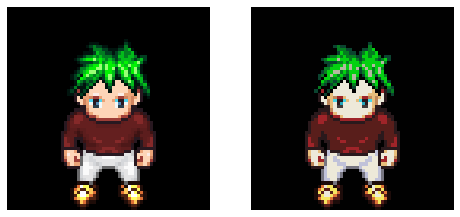

In [14]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
image_from_array(x)
fig.add_subplot(1, 2, 2)
image_from_array(x_hat, model_output=True)

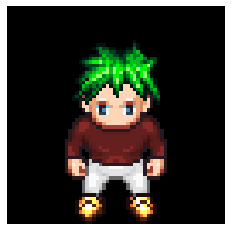

In [15]:
constant = dataset['0000']['front_slash0']
constant_encodings = model(constant.unsqueeze(0))[3]
image_from_array(constant)

In [16]:
Counter(list(constant_encodings.flatten().numpy())).most_common(1)[0][0]

209

In [17]:
encodings_hat = modify_encodings(encodings, background_encoding, num_embeddings, 19)
x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)

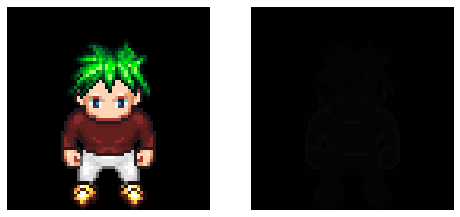

In [18]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
image_from_array(x)
fig.add_subplot(1, 2, 2)
image_from_array(x_hat, model_output=True)

In [19]:
all_generated = []
for i in range(256):
    encodings_hat = modify_encodings(encodings, constant_encodings, num_embeddings, i)
    x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)
    x_hat = x_hat.detach().squeeze(0).permute(1, 2, 0).numpy()
    x_hat = Image.fromarray((x_hat * 255).astype(np.uint8))
    all_generated.append(x_hat)

In [36]:
all_generated[0].save(
    fp="sprites.gif", format='GIF', append_images=all_generated[1:], save_all=True, duration=300, loop=0, optimize=False
)

# Palette Swap

In [20]:
def get_color_palette(encodings):
    colors, counts = encodings.unique(return_counts=True)
    return [int(x) for _, x in sorted(zip(counts, colors))][::-1]

In [21]:
def swap_palette(encoding, palette, new_palette):
    for old, new in zip(palette, new_palette):
        encoding[encoding == old] = new
    return encoding.unsqueeze(1)

In [22]:
def get_swapped_images(encodings):
    x1_encoding, x2_encoding = encodings.view(2, -1)
    x1_palette = get_color_palette(x1_encoding)
    x2_palette = get_color_palette(x2_encoding)
    x1_swapped = swap_palette(x1_encoding, x1_palette, x2_palette)
    x2_swapped = swap_palette(x2_encoding, x2_palette, x1_palette)
    return torch.cat([x1_swapped, x2_swapped])

In [23]:
background_encoding = 209
target_shape = (2, encoding_dim, encoding_dim, embedding_dim)

In [24]:
# ['0134', '0124', '0153', '0130', '0112', '0200', '0214', '0024', '0004', '0212']
x1 = dataset['0025']['front_slash0']
x2 = dataset['0020']['front_slash0']

In [25]:
encodings = model(torch.stack([x1, x2]))[3]
x_in = model.quantize_and_decode(encodings, target_shape, device)
encodings_hat = get_swapped_images(encodings)
x_hat = model.quantize_and_decode(encodings_hat, target_shape, device)

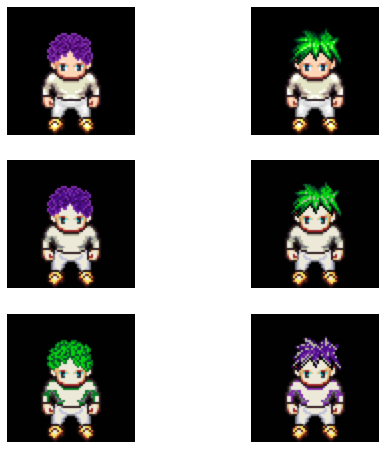

In [26]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(3, 2, 1)
image_from_array(x1)
fig.add_subplot(3, 2, 2)
image_from_array(x2)
fig.add_subplot(3, 2, 3)
image_from_array(x_in[0], True)
fig.add_subplot(3, 2, 4)
image_from_array(x_in[1], True)
fig.add_subplot(3, 2, 5)
image_from_array(x_hat[0], True)
fig.add_subplot(3, 2, 6)
image_from_array(x_hat[1], True)

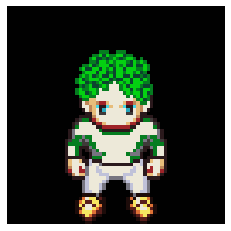

In [27]:
image_from_array(x_hat[0], model_output=True)

In [63]:
all_generated = []
for i in range(num_embeddings):
    temp = torch.tensor(np.zeros(shape=(encoding_dim * encoding_dim, 1)) + i, dtype=torch.int64)
    temp = model.quantize_and_decode(temp, (1, encoding_dim, encoding_dim, embedding_dim), device)
    temp = temp.detach().squeeze(0).permute(1, 2, 0).numpy()
    temp = Image.fromarray((temp * 255).astype(np.uint8))
    all_generated.append(temp)

In [64]:
all_generated = list(enumerate(all_generated))

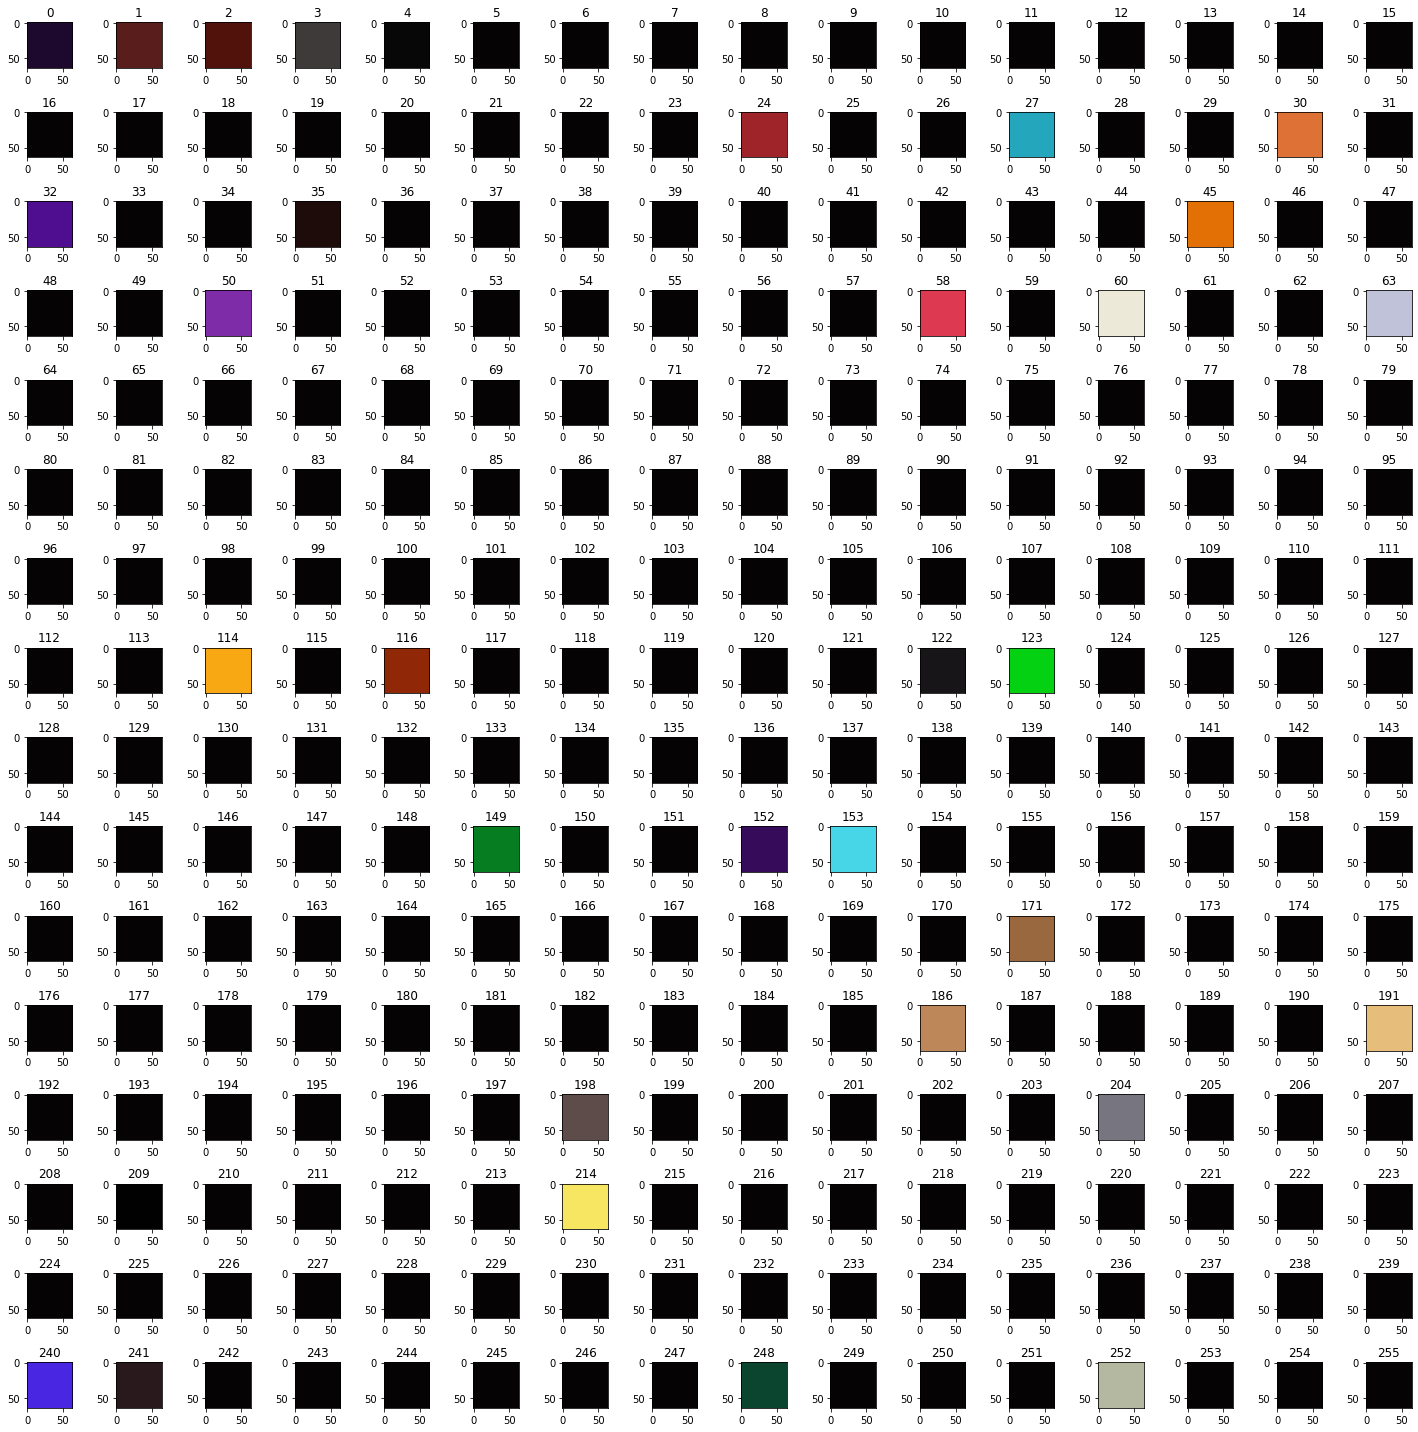

In [70]:
fig, axes = plt.subplots(nrows = 16, ncols = 16, figsize=(20,20))
for i in range(16):
    for j in range(16):
        axes[i, j].imshow(all_generated[i * 16 + j][1])
        axes[i, j].set_title(all_generated[i * 16 + j][0])
plt.tight_layout()
plt.show()

In [30]:
def color_swap(encodings, color_palette):
    x1_encoding = encodings.view(2, -1)[0]
    x1_palette = get_color_palette(x1_encoding)
    x1_swapped = swap_palette(x1_encoding, x1_palette, color_palette[:len(x1_palette)])
    return x1_swapped